In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torchinfo
from torch.utils.data import DataLoader
from torchlake.common.constants import IMAGENET_MEAN, IMAGENET_STD
from torchlake.image_classification.controller.trainer_inception import InceptionTrainer
from torchlake.common.controller.evaluator import ClassificationEvaluator
from torchlake.common.utils.platform import get_num_workers, get_file_size
from torchlake.image_classification.models.inceptionv2 import InceptionBN
from torchvision import transforms
from torchvision.datasets import GTSRB

# Setting

In [2]:
IMAGE_SIZE = 224
BATCH_SIZE = 32

In [3]:
artifact_path = Path("../../artifacts/inceptionv2")
artifact_path.mkdir(exist_ok=True)

data_path = Path("../../data/gtsrb")

In [4]:
DEVICE = torch.device("cuda:0")

# data

In [5]:
preprocess = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ]
)

In [6]:
train_dataset = GTSRB(
    data_path.as_posix(),
    split="train",
    transform=preprocess,
    download=True,
)

In [7]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    num_workers=get_num_workers(),
)

In [8]:
NUM_CLASS = 43

In [9]:
len(train_dataset)

26640

7


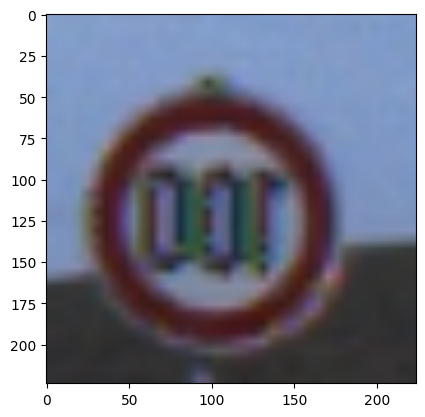

In [10]:
import random
from torchlake.common.utils.convert import img_tensor_to_np

demo_img, demo_label = random.choice(train_dataset)
print(demo_label)
plt.imshow((img_tensor_to_np(demo_img) * IMAGENET_STD + IMAGENET_MEAN).clip(0, 1))

# model

In [11]:
model = InceptionBN(output_size=NUM_CLASS).to(DEVICE)

In [12]:
torchinfo.summary(model)

Layer (type:depth-idx)                                  Param #
InceptionBN                                             --
├─Sequential: 1-1                                       --
│    └─Conv2dNormActivation: 2-1                        --
│    │    └─Conv2d: 3-1                                 192
│    │    └─BatchNorm2d: 3-2                            128
│    │    └─ReLU: 3-3                                   --
│    └─Conv2dNormActivation: 2-2                        --
│    │    └─Conv2d: 3-4                                 25,088
│    │    └─BatchNorm2d: 3-5                            128
│    │    └─ReLU: 3-6                                   --
│    └─MaxPool2d: 2-3                                   --
│    └─Conv2dNormActivation: 2-4                        --
│    │    └─Conv2d: 3-7                                 4,096
│    │    └─BatchNorm2d: 3-8                            128
│    │    └─ReLU: 3-9                                   --
│    └─Conv2dNormActivation: 2-5        

# training

In [13]:
EPOCHS = 10
ACC_ITERS = 1

In [14]:
trainer = InceptionTrainer(EPOCHS, DEVICE, ACC_ITERS)
trainer.recorder.increment_data_size(len(train_dataset))

In [15]:
criterion = trainer.get_criterion(NUM_CLASS)
optim = torch.optim.Adam(model.parameters(), lr=1e-3)

In [16]:
training_loss = trainer.run(train_loader, model, optim, criterion)

Enable AMP: False
Training...


100%|██████████| 832/832 [02:09<00:00,  6.45it/s]


------------------------------------
Epoch 1
------------------------------------
total: 2.8254e-01 (0.00%)


100%|██████████| 832/832 [02:10<00:00,  6.37it/s]


------------------------------------
Epoch 2
------------------------------------
total: 1.8076e-01 (-36.00%)


100%|██████████| 832/832 [02:07<00:00,  6.54it/s]


------------------------------------
Epoch 3
------------------------------------
total: 9.5857e-02 (-47.00%)


100%|██████████| 832/832 [02:07<00:00,  6.52it/s]


------------------------------------
Epoch 4
------------------------------------
total: 5.3702e-02 (-44.00%)


100%|██████████| 832/832 [02:07<00:00,  6.55it/s]


------------------------------------
Epoch 5
------------------------------------
total: 3.7620e-02 (-30.00%)


100%|██████████| 832/832 [02:07<00:00,  6.51it/s]


------------------------------------
Epoch 6
------------------------------------
total: 2.8765e-02 (-24.00%)


100%|██████████| 832/832 [02:09<00:00,  6.44it/s]


------------------------------------
Epoch 7
------------------------------------
total: 2.3860e-02 (-17.00%)


100%|██████████| 832/832 [02:08<00:00,  6.48it/s]


------------------------------------
Epoch 8
------------------------------------
total: 2.0511e-02 (-14.00%)


100%|██████████| 832/832 [02:06<00:00,  6.59it/s]


------------------------------------
Epoch 9
------------------------------------
total: 1.9524e-02 (-5.00%)


100%|██████████| 832/832 [02:06<00:00,  6.59it/s]

------------------------------------
Epoch 10
------------------------------------
total: 1.6052e-02 (-18.00%)


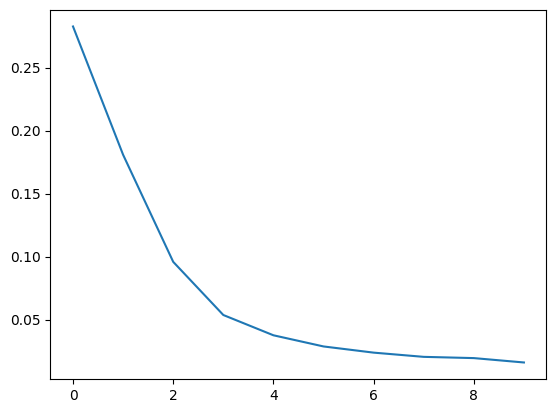

In [17]:
plt.plot(training_loss)

# inference

In [18]:
test_preprocess = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

In [19]:
test_dataset = GTSRB(
    data_path.as_posix(),
    split="test",
    transform=test_preprocess,
    download=True,
)

In [20]:
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    pin_memory=True,
    num_workers=get_num_workers(),
)

In [21]:
evaluator = ClassificationEvaluator(NUM_CLASS, DEVICE)

In [22]:
confusion_matrix = evaluator.run(test_loader, model)

100%|██████████| 395/395 [00:30<00:00, 12.85it/s]


In [23]:
per_class_acc = evaluator.get_per_class_accuracy(confusion_matrix)
evaluator.show_per_class_accuracy(range(NUM_CLASS), per_class_acc)

0         : 1.0
1         : 1.0
2         : 0.9933333333333333
3         : 0.98
4         : 0.9696969696969697
5         : 0.9857142857142858
6         : 0.9333333333333333
7         : 0.9933333333333333
8         : 0.9266666666666666
9         : 1.0
10        : 1.0
11        : 1.0
12        : 0.9376811594202898
13        : 0.9972222222222222
14        : 1.0
15        : 0.9904761904761905
16        : 1.0
17        : 0.9166666666666666
18        : 0.9743589743589743
19        : 1.0
20        : 0.36666666666666664
21        : 0.6666666666666666
22        : 0.8083333333333333
23        : 0.9866666666666667
24        : 0.9333333333333333
25        : 0.95
26        : 1.0
27        : 0.36666666666666664
28        : 1.0
29        : 1.0
30        : 0.8133333333333334
31        : 0.9851851851851852
32        : 1.0
33        : 0.9428571428571428
34        : 0.8583333333333333
35        : 0.9923076923076923
36        : 0.6166666666666667
37        : 0.8333333333333334
38        : 0.97826086956521

In [24]:
per_class_acc.mean()

np.float64(0.8879169153132751)

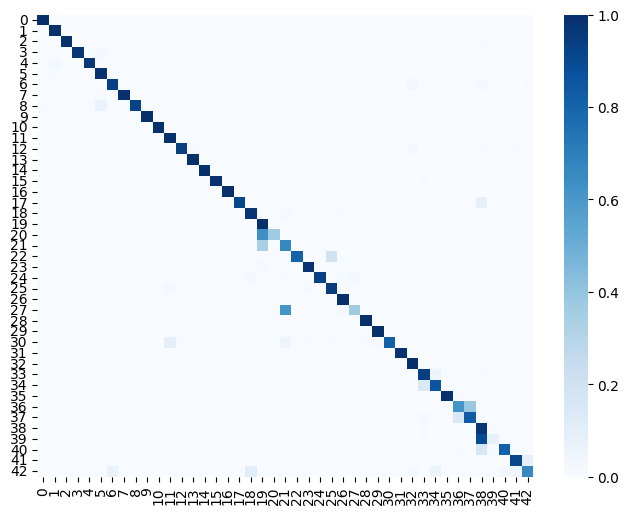

In [25]:
evaluator.plot_confusion_matrix(
    confusion_matrix,
    range(NUM_CLASS),
    "Blues",
    annot=False,
    figsize=(8, 6),
)

In [26]:
model_path = artifact_path / f'inception.bn.pth'

In [27]:
torch.save(model.state_dict(), model_path)

In [28]:
get_file_size(model_path)

'41.52MiB'

In [29]:
model.load_state_dict(torch.load(model_path.as_posix()))

<All keys matched successfully>